## Sprint1 Feb/01 
Week4の授業課題の続き利用して進める。
Sprint1からの変更は下の方にある

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
def gen_range(value_start, value_end, value_step):
    """
    range関数を小数点が扱えるように拡張。value_startから始めてvalue_endに到達するまでvalue_stepを加え続ける。計算を実行する毎にその値を返す。
    ----------------
    Parameter
        value_start:float
        value_end:float
        value_step:float
    ----------------
    ----------------
    Return
    　　value:float value_minにvalue_stepを加えた値
    ----------------
    """
    value = value_start
    while value+value_step < value_end:
     yield value
     value += value_step

In [3]:
def binning_data(data_source, col_name, binned_col_name, num_of_bin=10, option="IQR"):
    """
    指定された列を指定されたbinの数に分割し、bin毎にラベル付けされたデータを元データに追加する
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    binned_col_name : string 
    num_of_bin : int
    
    return
    --------------
    data_source : pandas dataframe
    
    """
    
    if option == "IQR":
        #bin幅の決定のため四分位数を調べる。（外れ値を除く）
        data_info = data_source.describe()
        bin_min = data_info.loc["25%", col_name]
        bin_max = data_info.loc["75%", col_name]
        IQR = bin_max - bin_min
        bin_min = bin_min-IQR*1.5 if bin_min > IQR*1.5 else 0 #これ以下は外れ値とする。(0を最低値とする)
        bin_max += IQR*1.5 #これ以上は外れ値とする
        bin_min = (int)(bin_min)
        bin_max = (int)(bin_max)+1
    elif option == "MINMAX":
        data_info = data_source.describe()
        bin_min = (int)(data_info.loc["min", col_name])
        bin_max = (int)(data_info.loc["max", col_name])+1    
    
    bin_width = (int)((bin_max - bin_min) / num_of_bin)
    bins = [value for value in range(bin_min, bin_max, bin_width)]
    #bin_width = (bin_max - bin_min) / num_of_bin
    #bins = [value for value in gen_range(bin_min, bin_max, bin_width )]
    labels = [i for i in range(0, len(bins)-1)]
    binned_label = pd.cut(data_source[col_name], bins=bins, labels=labels)
    data_source[binned_col_name] = binned_label

    for i in range(0, len(bins)-1):
        print("range label={} : range={:.5f}~{:.5f}".format(i, bins[i], bins[i+1]) )
    
    return data_source

In [4]:
def plot_non_repayment_rate(data_source, col_name, flag_rename_x_label=False):
    """
    X軸を指定された列として未偏差率を棒グラフでプロット
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    flag_rename_x_label : bool
    
    return
    --------------
    None
    """
    
    #ラベル毎に返済率を算出
    non_repayment_rate = data_source.groupby(col_name, as_index=False).mean()
    non_repayment_rate["TARGET"] *= 100
    #print(non_repayment_rate)
    
    #Bar plot
    plt.figure(figsize=(25,10))
    plt.bar(non_repayment_rate.index, non_repayment_rate["TARGET"], color="Blue")
    plt.xlabel(col_name, fontsize=18)
    plt.ylabel("Non-payment rate[%]", fontsize=18)
    plt.title("Non-payment rate")
    plt.tight_layout()
    
    #グラフ上に数値表示
    """
    for x, y in zip(non_repayment_rate.index, non_repayment_rate["TARGET"]):
        plt.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
        if flag_rename_x_label == True:
            plt.xticks(non_repayment_rate.index, non_repayment_rate[col_name]) #x軸を実際のデータラベルへ置き換え
    """
    plt.show()

### 【問題1】パイプラインの作成
授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

### パイプライン関数

In [107]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipeline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return result, fpr, tpr, thresholds

### 試しにirisデータで計算してみる  
期待通り動いていそう。

In [6]:
from sklearn.datasets import load_iris
iris_data_set = load_iris()
x = pd.DataFrame(iris_data_set.data, columns=iris_data_set.feature_names)    #Put explanatory variable into x as pandasdata frame
y = pd.DataFrame(iris_data_set.target, columns=['Species'])    #Put iris response variable into y as pandasdata frame
df = pd.concat([x, y], axis=1)
data = df[df["Species"] != 0]

元データ数：100　学習データ数：75　検証データ数：25


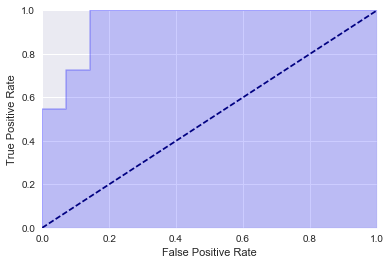

Result=[0.02 0.   0.   0.99 1.   1.   0.59 0.   0.94 0.92 1.   1.   0.59 0.03
 0.01 0.93 0.8  0.45 1.   1.   0.   0.77 0.83 0.99 0.16]
FPR=[0.         0.         0.         0.07142857 0.07142857 0.14285714
 0.14285714 0.42857143 0.57142857 1.        ]
TPR=[0.         0.36363636 0.54545455 0.54545455 0.72727273 0.81818182
 1.         1.         1.         1.        ]
Thresholds=[2.   1.   0.98 0.97 0.55 0.41 0.2  0.06 0.01 0.  ]


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=10)
#clf = KNeighborsClassifier(n_neighbors=3)

result, fpr, tpr, thresholds = pipline(clf, data, "Species", data.columns[[0,2]], 2, False)

print("Result={}".format(result[:,0]))
print("FPR={}".format(fpr))
print("TPR={}".format(tpr))
print("Thresholds={}".format(thresholds))

### 実際に計算

特徴量を選ぶ(とりあえず前回のEDAの結果)  
1.OCCUPATION_TYPE  
2.ORGANIZATION_TYPE  
5.DAYS_EMPLOYED  
6.DAYS_REGISTRATION  
7.AMT_CREDIT  
8.DAYS_BIRTH  
9.DEF_60_CNT_SOCIAL_CIRCLE  
10.AMT_INCOME_TOTAL  
11.CNT_CHILDREN  

In [8]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL", 
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [9]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [10]:
pd_reducted_train_data = pd_application_train[col_name]

In [11]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


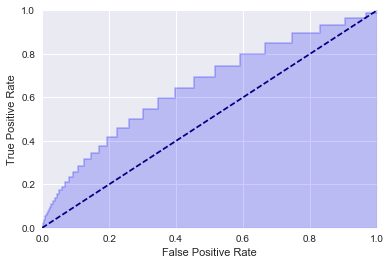

AUC=0.67154


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#clf = KNeighborsClassifier(n_neighbors=5)
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipeline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

モデルのパラメータ調整？？

### 【問題2】指標値の関数作成
このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）
このAUCを計算する関数を作成してください。

In [13]:
def cal_auc(fpr, tpr):
    
    dx = fpr[1:]-fpr[:-1]     #X軸（fpr）について配列の隣同士の間隔を計算
    dy = (tpr[1:]+tpr[:-1])/2 #Y軸(tpr)について配列の右隣との平均値を計算
    integral = dx*dy
    """
    integral_under = dx * tpr[0:len(tpr)-1]
    integral_over = dx * tpr[1:len(tpr)]
    auc = (integral_under.sum()+integral_over.sum())/2
    """
    return integral.sum()

#### AUCを計算 (Sklearn Metric.aucの計算結果と比較)  
結果、sklearnによる計算結果と一致した。

In [14]:
print("AUC(with cal_auc)={:.6f}".format(cal_auc(fpr, tpr)))
print("AUC(with metrics.auc)={:.6f}".format(metrics.auc(fpr, tpr)))

AUC(with cal_auc)=0.671544
AUC(with metrics.auc)=0.671544


### 【問題3】前処理・Feature Engineering・学習
精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。
汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

#### アプローチ ：データセットに新たな特徴量を加えてみる
負債を抱える人は、  
・複数ローンをしている  
・自己管理ができない、時間にルーズなど”いい加減” 
という特徴があるようだ。(ただし日本国内での調査結果に基づく)。
このことは、Week3 Seesion1で行なったEDAの結果、収入の他にその人物の特徴も重要な要素であるという推測と一致する。そこで、Home creditから与えられているデータを組み合わせ”いい加減”という特徴を数値化し新しい特徴量とすることを試みる。  
また、負債を抱えてしまった理由としては、  
・収入が少ない&収入の減少  
が上位に挙げられていた。しかしWeek3 Seesion1で行なったEDAの結果、単純に収入だけでは未返済率にはっきりとした傾向は現れていなかった。そこで、新たなアプローチとして収入と必要な出費から"経済的な余裕の無さ"を数値化し新しい特徴量とすることを試みる。必要な出費の多さの指標として”子供の多さ”を用いる。

| ”無計画” & ”いい加減” の定義　| 組み合わせる特徴量 |　新しい特徴量の算出方法 |
|:-----------:|:------------:|:------------:|
| 収入低いのに多く借りている |　AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICE | 得点化 |
| Nanの欄が多い | Nan | サンプル毎のNanの合計値の分布を適当なレンジに分ける。 |

| ”経済的な余裕のなさ”の定義| 組み合わせる特徴量 |　新しい特徴量の算出方法 |
|:-----------:|:------------:|:------------:|
| 収入が低く子供が多い　　　|　　　AMT_INCOME_TOTAL, CNT_CHILDREN　　　 | 　得点化 （収入=低い&子供多い=>大 　収入=高い&子供少い=>大）|

AMT_INCOME_TOTAL、 CNT_CHILDREN、AMT_CREDIT、 AMT_GOODS_PRICE、 Nanの分布を見てみる。

In [15]:
col_name = ["TARGET", "AMT_INCOME_TOTAL", "CNT_CHILDREN", "AMT_CREDIT", "AMT_GOODS_PRICE"]
pd_data = pd_application_train[col_name]
pd_data.head()

,TARGET,AMT_INCOME_TOTAL,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE
0,1,202500.0,0,406597.5,351000.0
1,0,270000.0,0,1293502.5,1129500.0
2,0,67500.0,0,135000.0,135000.0
3,0,135000.0,0,312682.5,297000.0
4,0,121500.0,0,513000.0,513000.0


In [16]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 5 columns):
TARGET              307511 non-null int64
AMT_INCOME_TOTAL    307511 non-null float64
CNT_CHILDREN        307511 non-null int64
AMT_CREDIT          307511 non-null float64
AMT_GOODS_PRICE     307233 non-null float64
dtypes: float64(3), int64(2)
memory usage: 11.7 MB


In [17]:
pd_data.describe()

,TARGET,AMT_INCOME_TOTAL,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE
count,307511.000000,3.075110e+05,307511.000000,3.075110e+05,3.072330e+05
mean,0.080729,1.687979e+05,0.417052,5.990260e+05,5.383962e+05
std,0.272419,2.371231e+05,0.722121,4.024908e+05,3.694465e+05
min,0.000000,2.565000e+04,0.000000,4.500000e+04,4.050000e+04
25%,0.000000,1.125000e+05,0.000000,2.700000e+05,2.385000e+05
50%,0.000000,1.471500e+05,0.000000,5.135310e+05,4.500000e+05
75%,0.000000,2.025000e+05,1.000000,8.086500e+05,6.795000e+05
max,1.000000,1.170000e+08,19.000000,4.050000e+06,4.050000e+06


#### 1."収入低いのに多く借りている"について、AMT_INCOME_TOTAL, AMT_CREDIT, AMT_GOODS_PRICEから数値化

income
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
AMT_CREDIT


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


range label=0 : range=0.00000~202078.00000
range label=1 : range=202078.00000~404156.00000
range label=2 : range=404156.00000~606234.00000
range label=3 : range=606234.00000~808312.00000
range label=4 : range=808312.00000~1010390.00000
range label=5 : range=1010390.00000~1212468.00000
range label=6 : range=1212468.00000~1414546.00000
range label=7 : range=1414546.00000~1616624.00000
AMT_GOODS_PRICE
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000


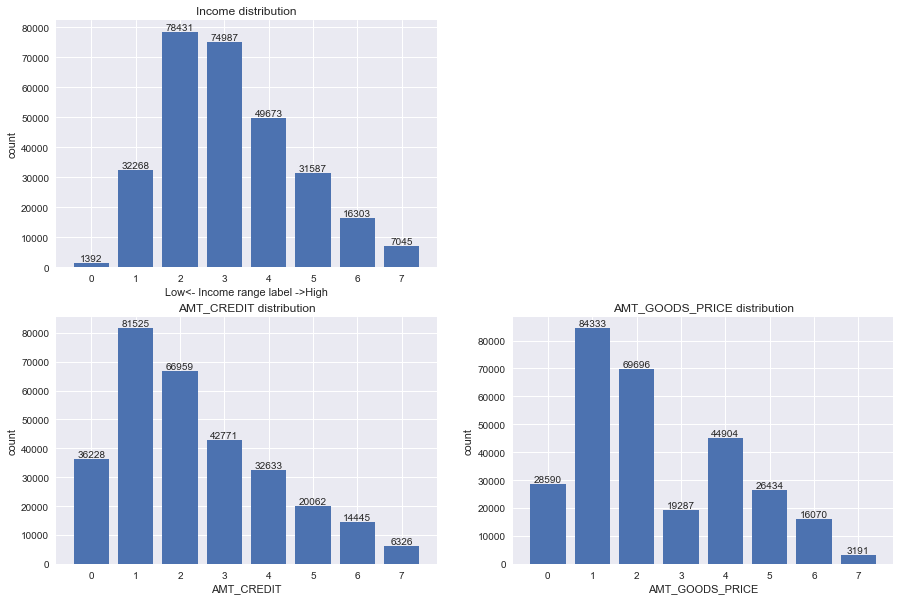

In [18]:
#Income range と 子供の数をcount plot
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (1,1))

ax1.set_title('Income distribution')
ax1.set_xlabel('Low<- Income range label ->High')
ax1.set_ylabel('count')
ax1.grid(True)

ax2.set_title('AMT_CREDIT distribution')
ax2.set_xlabel('AMT_CREDIT')
ax2.set_ylabel('count')
#plt.xlim([-1,15])
#plt.yscale("log")
ax2.grid(True)

ax3.set_title('AMT_GOODS_PRICE distribution')
ax3.set_xlabel('AMT_GOODS_PRICE')
ax3.set_ylabel('count')
#plt.xlim([-1,15])
#cale("log")
ax3.grid(True)

#Income
print("income")
tmp = binning_data(pd_data, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_INCOME_TOTAL", as_index=False).count()
ax1.bar(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
                , income_destribution_w_income_range["TARGET"]):
    ax1.text(x, y, y, ha='center', va='bottom')

#AMT_CREDIT
print("AMT_CREDIT")
tmp = binning_data(pd_data, "AMT_CREDIT", "BIN_AMT_CREDIT", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_CREDIT", as_index=False).count()
ax2.bar(income_destribution_w_income_range["BIN_AMT_CREDIT"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_CREDIT"]
                , income_destribution_w_income_range["TARGET"]):
    ax2.text(x, y, y, ha='center', va='bottom')

#AMT_GOODS_PRICE
print("AMT_GOODS_PRICE")
tmp = binning_data(pd_data, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_GOODS_PRICE", as_index=False).count()
ax3.bar(income_destribution_w_income_range["BIN_AMT_GOODS_PRICE"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_GOODS_PRICE"]
                , income_destribution_w_income_range["TARGET"]):
    ax3.text(x, y, y, ha='center', va='bottom')
    
plt.show()

３つの特徴量は数値の高い方向に外れ値を持っており、この値はレンジ分けする際に範囲外"Nan"となっている。新しい指標を導入する際にこのNanは全て10に置き換える。  

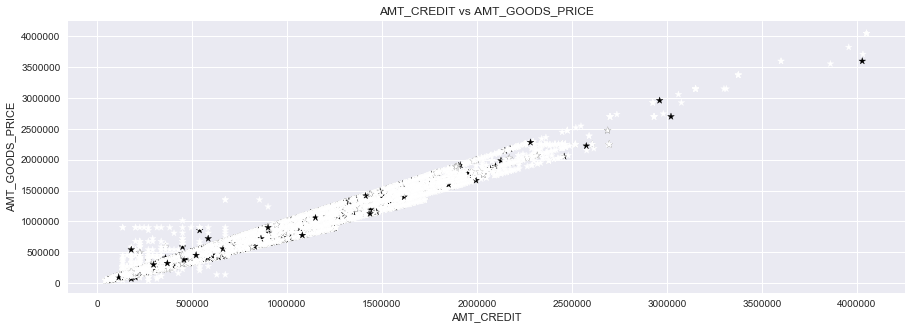

In [19]:
plt.figure(figsize=(15,5))
plt.title('AMT_CREDIT vs AMT_GOODS_PRICE')
plt.xlabel('AMT_CREDIT')
plt.ylabel('AMT_GOODS_PRICE')
plt.scatter(pd_data["AMT_CREDIT"], pd_data["AMT_GOODS_PRICE"], s=50, c=pd_data["TARGET"], marker='*')
plt.show()

In [20]:
x = pd_data["AMT_CREDIT"]
y = pd_data["AMT_GOODS_PRICE"]
x = x.replace(np.nan, -1)
y = y.replace(np.nan, -1)
np.corrcoef(x, y)

array([[1.       , 0.9866873],
       [0.9866873, 1.       ]])

"AMT_CREDIT" と "AMT_GOODS_PRICE"の相関係数はほぼ１なので、新しい指標の算出にはどちらか一方を用いる。
ここでは"AMT_GOODS_PRICE"を用いる。

"収入低いのに多く借りている"について、新しい指標を次のように定義する。  
(10 - INCOME_RANGE) $\times$ (1 + GOODS_PRICE_RANGE)  
以下、新しい指標をデータセットに追加する。  
  
＊(10 - INCOME_RANGE) => 収入が低いほど値が高い。INCOME_RANGEは値が低いほど収入が低いため、意味合いを逆転させるために10からINCOME_RANGEを引いた。(INCOME_RANGEの最大値は10)  
＊(1 + GOODS_PRICE_RANGE) => 借入額が高いほど値が高い。GOODS_PRICE_RANGEが0から始まるため１を加えた。  

In [21]:
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000


In [22]:
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"].describe()

count    292505.000000
mean         21.528658
std          12.136719
min           0.000000
25%          14.000000
50%          18.000000
75%          28.000000
max          80.000000
Name: DEG_IRESP_INCOME_GOODS_PRICE, dtype: float64

新しい指標"DEG_IRESP_INCOME_GOODS_PRICE"の有効性を確認するために未返済率との関係を見てみる。

range label=0 : range=0.00000~10.00000
range label=1 : range=10.00000~20.00000
range label=2 : range=20.00000~30.00000
range label=3 : range=30.00000~40.00000
range label=4 : range=40.00000~50.00000
range label=5 : range=50.00000~60.00000
range label=6 : range=60.00000~70.00000
range label=7 : range=70.00000~80.00000


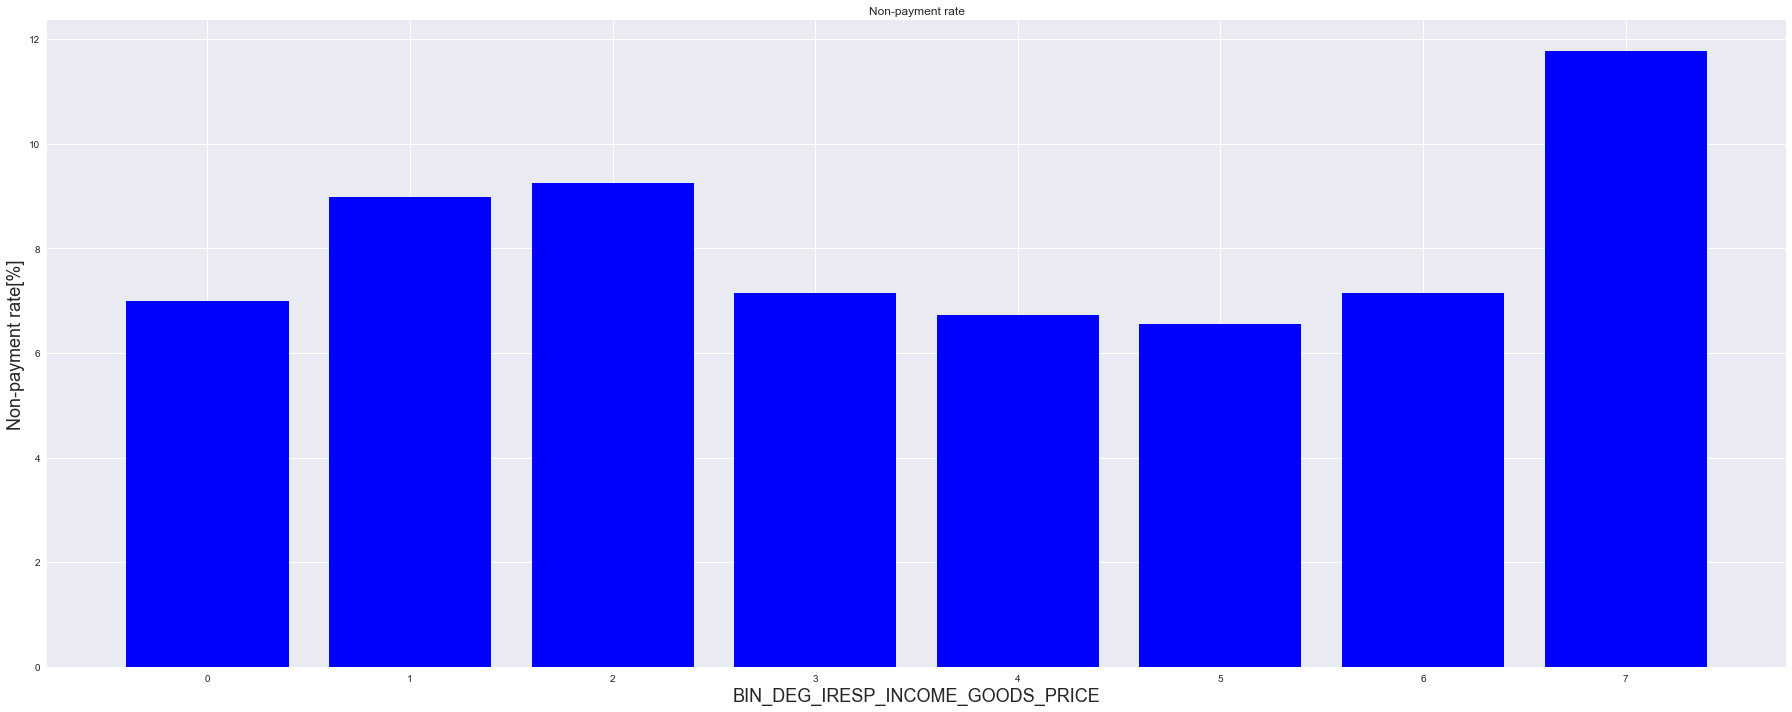

In [23]:
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")
plot_non_repayment_rate(pd_application_train, 'BIN_DEG_IRESP_INCOME_GOODS_PRICE', False)

期待としては、新しい指標"DEG_IRESP_INCOME_GOODS_PRICE"が大きいほど未返済率が大きいだったが、実際に指標を導入して関係を調べてみた結果、期待したような右肩あがりの関係は見えられなかった。  
よって、新しい指標"DEG_IRESP_INCOME_GOODS_PRICE"は未返済率の予測に適用しない。

#### 2."Nanの欄が多い"について
index毎にNanの合計値を算出する。適当なレンジに分けてNanの数の分布を見てみる。Nanが多い＝いい加減と考える。

In [24]:
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)

In [25]:
pd_application_train["NUM_OF_NAN"].describe()

count    307511.000000
mean         29.949976
std          20.883310
min           0.000000
25%           6.000000
50%          37.000000
75%          49.000000
max          64.000000
Name: NUM_OF_NAN, dtype: float64

range label=0 : range=0.00000~6.00000
range label=1 : range=6.00000~12.00000
range label=2 : range=12.00000~18.00000
range label=3 : range=18.00000~24.00000
range label=4 : range=24.00000~30.00000
range label=5 : range=30.00000~36.00000
range label=6 : range=36.00000~42.00000
range label=7 : range=42.00000~48.00000
range label=8 : range=48.00000~54.00000
range label=9 : range=54.00000~60.00000


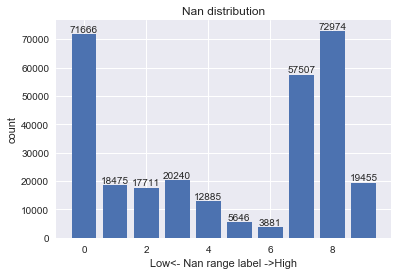

In [26]:
tmp = binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")
nan_destribution_w_range = tmp.groupby("BIN_NUM_OF_NAN", as_index=False).count()

plt.title('Nan distribution')
plt.xlabel('Low<- Nan range label ->High')
plt.ylabel('count')
plt.grid(True)
plt.bar(nan_destribution_w_range["BIN_NUM_OF_NAN"]
        , nan_destribution_w_range["TARGET"])

for x, y in zip(nan_destribution_w_range["BIN_NUM_OF_NAN"]
                , nan_destribution_w_range["TARGET"]):
    plt.text(x, y, y, ha='center', va='bottom')

Nanの合計の分布を見てみると、Range0(Nanの数が0~6)のきっちりアンケートを記入しているグループとRange7~9(Nanの数が42~60)の比較的未記入が多いグループにざっくり分かれている。Range7~9はアンケート回答者の全体の半数を占める。
Range0のグループは、質問数の多さにも関わらずきっちり回答しており真面目な性格だと予想できる。
以下、未返済率との関係を調べてみる。

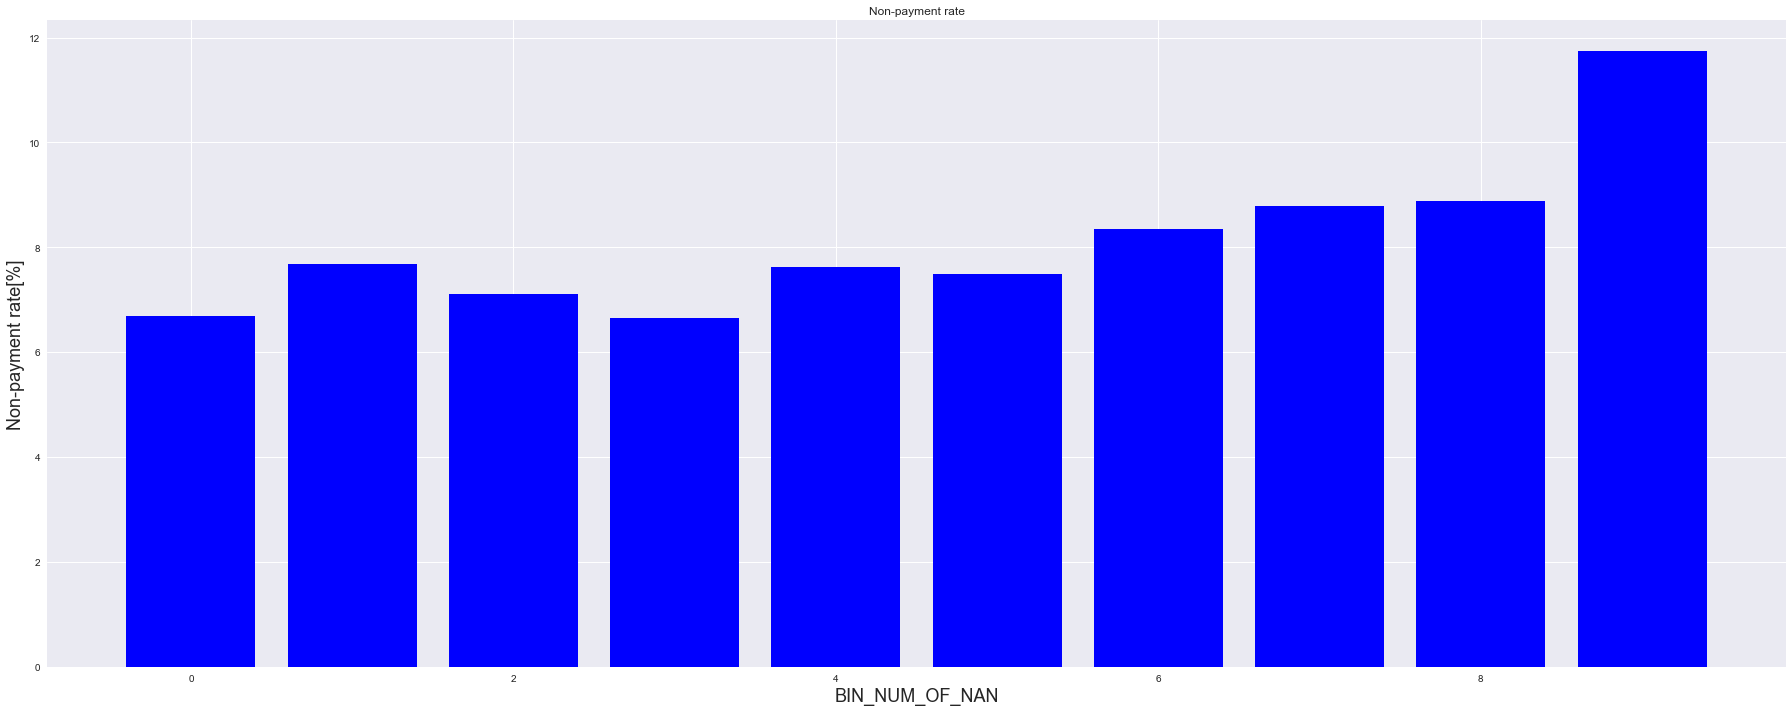

In [27]:
plot_non_repayment_rate(pd_application_train, 'BIN_NUM_OF_NAN', False)

プロットからは僅かであるが右肩上がりの傾向が見える。つまり、Nanが少ないほど未返済率が低く、Nanが多いほど未返済率が高い傾向があると言えそうだ。特にRange0とRange9では約2倍近い差が出ている。よって、Nanの数は未返済率の予測に使えそうな特徴量である。

#### 3."”経済的な余裕のなさ”の数値化について

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000


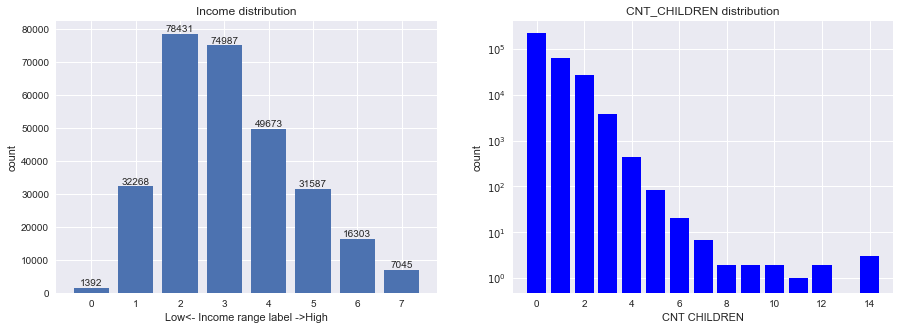

In [28]:
#Income range と 子供の数をcount plot
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))


ax1.set_title('Income distribution')
ax1.set_xlabel('Low<- Income range label ->High')
ax1.set_ylabel('count')
ax1.grid(True)

ax2.set_title('CNT_CHILDREN distribution')
ax2.set_xlabel('CNT CHILDREN')
ax2.set_ylabel('count')
plt.yscale("log")
plt.xlim([-1,15])
ax2.grid(True)

#Income
tmp = binning_data(pd_data, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
income_destribution_w_income_range = tmp.groupby("BIN_AMT_INCOME_TOTAL", as_index=False).count()
ax1.bar(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
        , income_destribution_w_income_range["TARGET"])

for x, y in zip(income_destribution_w_income_range["BIN_AMT_INCOME_TOTAL"]
                , income_destribution_w_income_range["TARGET"]):
    ax1.text(x, y, y, ha='center', va='bottom')

#子供の数
cnt_children_destribution = tmp.groupby("CNT_CHILDREN", as_index=False).count()
ax2.bar(cnt_children_destribution["CNT_CHILDREN"], cnt_children_destribution["TARGET"], color="Blue")
    
#グラフ上に数値表示
"""
for x, y in zip(cnt_children_destribution.index, cnt_children_destribution["TARGET"]):
    ax2.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
"""
plt.show()

顧客の半分ほどは子供がいないことがわかった。利用者は未婚、若者が多い可能性がある。

"経済的な余裕のなさ"について、新しい指標として(10 - INCOME_RANGE) $\times$ CNT_CHILDRENを導入する。  
この値はその人物の経済的な負荷を表す。（収入が少なくて子供多い=>大 　収入が多くて子供少ない=>小）  
AMT_INCOME_TOTALには収入が高い方向に大きな外れ値が存在していて、この値はINCOME_RANGEでは範囲外"Nan"となっている。新しい指標を導入する際にこのNanは全て10に置き換える。

In [29]:
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000


In [30]:
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"].describe()

count    307511.000000
mean          9.167067
std           5.696633
min           0.000000
25%           6.000000
50%           8.000000
75%          10.000000
max         160.000000
Name: DEG_SEVERITY_INCOME_CNT_CHILDREN, dtype: float64

In [31]:
binning_data(pd_application_train, "DEG_SEVERITY_INCOME_CNT_CHILDREN", "BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN", 10, "MINMAX" )
"""
"""

range label=0 : range=0.00000~16.00000
range label=1 : range=16.00000~32.00000
range label=2 : range=32.00000~48.00000
range label=3 : range=48.00000~64.00000
range label=4 : range=64.00000~80.00000
range label=5 : range=80.00000~96.00000
range label=6 : range=96.00000~112.00000
range label=7 : range=112.00000~128.00000
range label=8 : range=128.00000~144.00000
range label=9 : range=144.00000~160.00000


'\n'

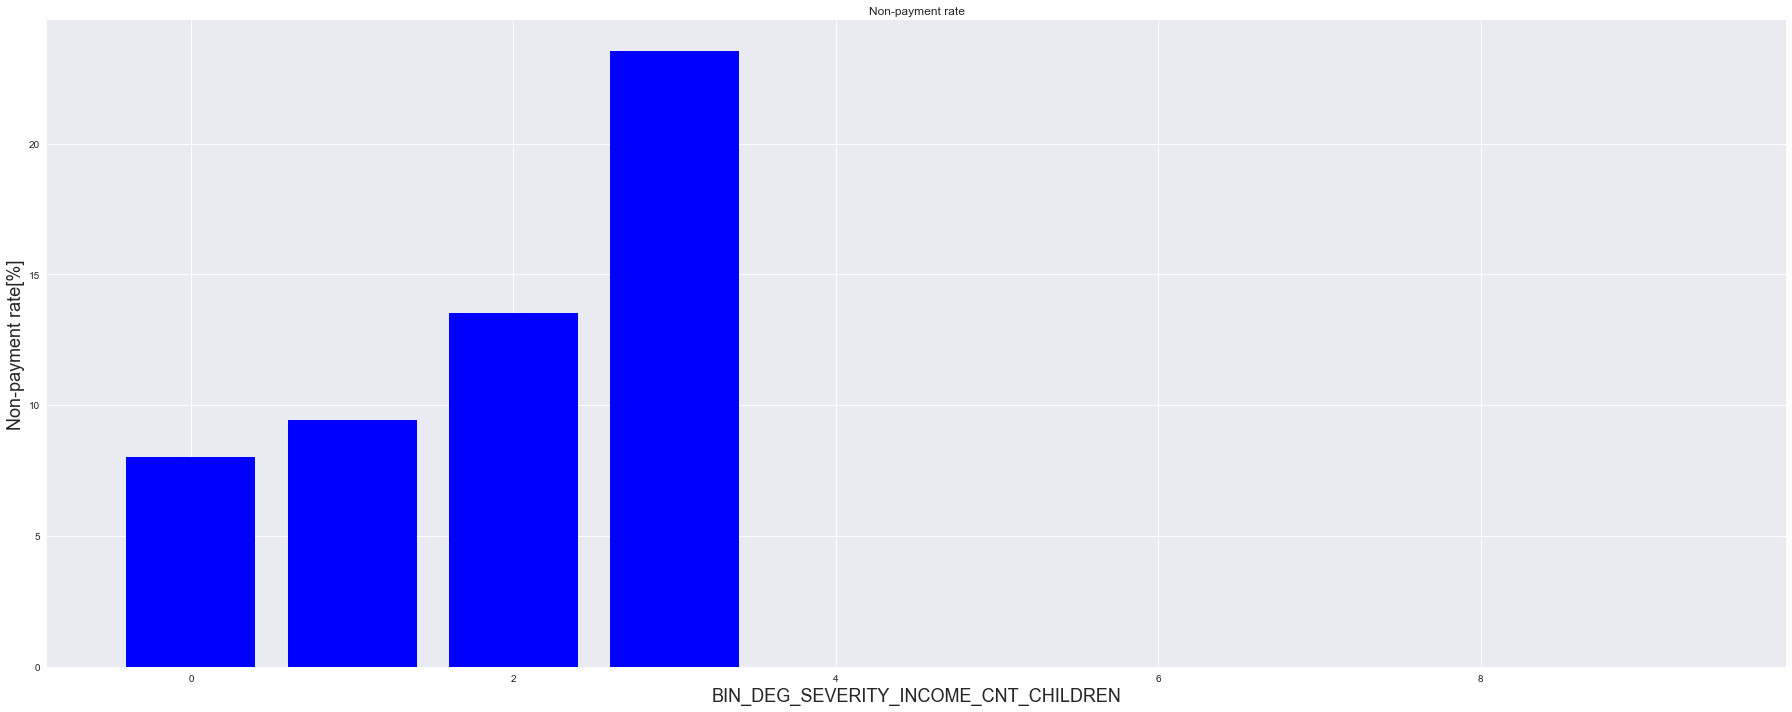

In [32]:
plot_non_repayment_rate(pd_application_train, 'BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN', False)

新しい特徴量"DEG_SEVERITY_INCOME_CNT_CHILDREN"は顧客の経済的な負担を数値化したもので、数値の増加ととも未返済率が増えると考えられる。
プロットのrange4以降はサンプル数が0~2しかなく且つ"Target"が0であるため未返済率は0と計算されている。そのためサンプルが集中しているRange0~3の間で考察を行うと期待した右肩あがりの傾向が見える。
よって、特徴量"DEG_SEVERITY_INCOME_CNT_CHILDREN"は未返済率の予測に使えそうな特徴量であると考えられる。

#### 新しい特徴量を加えてランダムフォレストで重要度を調べてみる

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [34]:
#SK_ID_CURRを削除する
pd_test = pd_application_train.drop("SK_ID_CURR", axis=1)
pd_test.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIN_AMT_INCOME_TOTAL,BIN_AMT_GOODS_PRICE,DEG_IRESP_INCOME_GOODS_PRICE,BIN_DEG_IRESP_INCOME_GOODS_PRICE,NUM_OF_NAN,BIN_NUM_OF_NAN,DEG_SEVERITY_INCOME_CNT_CHILDREN,BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,...,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2,18.0,1,1,0,6.0,0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,...,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6,28.0,2,2,0,4.0,0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [35]:
#オブジェクト型を数値に置き換え
object_col_name = pd_test.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_test[object_col_name[i]])
    pd_test[object_col_name[i]] = labels    

pd_test = pd_test.replace(np.nan, -1)

In [36]:
#ランダムフォレストを使って各パラメータの重要度を調べる
target = pd_test['TARGET']
feature = pd_test.iloc[:,1:len(pd_test.columns)]
model.fit(feature, target)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

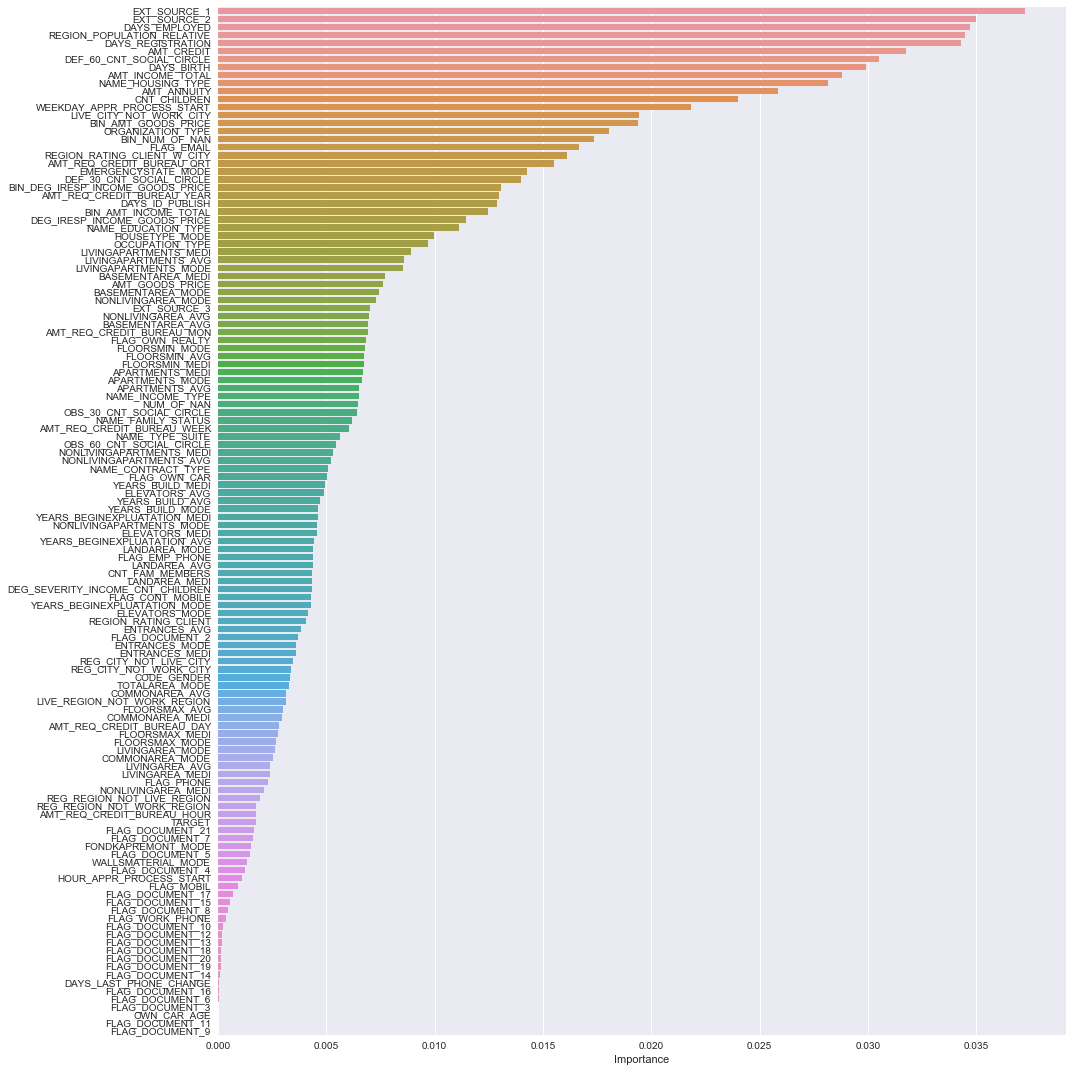

In [37]:
rank = np.argsort(-model.feature_importances_)
f, ax = plt.subplots(figsize=(15, 15)) 
sns.barplot(x=model.feature_importances_[rank], y=pd_test.columns.values[rank], orient='h')
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

In [38]:
#上位10個の特徴量を抽出
for i in range(0, 30):
    print("Rank{} => {} (Importance={:.3f})".format(i+1, pd_test.columns.values[rank[i]], model.feature_importances_[rank[i]]))

Rank1 => EXT_SOURCE_1 (Importance=0.037)
Rank2 => EXT_SOURCE_2 (Importance=0.035)
Rank3 => DAYS_EMPLOYED (Importance=0.035)
Rank4 => REGION_POPULATION_RELATIVE (Importance=0.035)
Rank5 => DAYS_REGISTRATION (Importance=0.034)
Rank6 => AMT_CREDIT (Importance=0.032)
Rank7 => DEF_60_CNT_SOCIAL_CIRCLE (Importance=0.031)
Rank8 => DAYS_BIRTH (Importance=0.030)
Rank9 => AMT_INCOME_TOTAL (Importance=0.029)
Rank10 => NAME_HOUSING_TYPE (Importance=0.028)
Rank11 => AMT_ANNUITY (Importance=0.026)
Rank12 => CNT_CHILDREN (Importance=0.024)
Rank13 => WEEKDAY_APPR_PROCESS_START (Importance=0.022)
Rank14 => LIVE_CITY_NOT_WORK_CITY (Importance=0.019)
Rank15 => BIN_AMT_GOODS_PRICE (Importance=0.019)
Rank16 => ORGANIZATION_TYPE (Importance=0.018)
Rank17 => BIN_NUM_OF_NAN (Importance=0.017)
Rank18 => FLAG_EMAIL (Importance=0.017)
Rank19 => REGION_RATING_CLIENT_W_CITY (Importance=0.016)
Rank20 => AMT_REQ_CREDIT_BUREAU_QRT (Importance=0.016)
Rank21 => EMERGENCYSTATE_MODE (Importance=0.014)
Rank22 => DEF_30_CN

In [39]:
TOP_THIRTY_COL_NAME = np.array([pd_test.columns.values[rank[i]] for i in range(0, 30)])
print(TOP_THIRTY_COL_NAME)

['EXT_SOURCE_1' 'EXT_SOURCE_2' 'DAYS_EMPLOYED'
 'REGION_POPULATION_RELATIVE' 'DAYS_REGISTRATION' 'AMT_CREDIT'
 'DEF_60_CNT_SOCIAL_CIRCLE' 'DAYS_BIRTH' 'AMT_INCOME_TOTAL'
 'NAME_HOUSING_TYPE' 'AMT_ANNUITY' 'CNT_CHILDREN'
 'WEEKDAY_APPR_PROCESS_START' 'LIVE_CITY_NOT_WORK_CITY'
 'BIN_AMT_GOODS_PRICE' 'ORGANIZATION_TYPE' 'BIN_NUM_OF_NAN' 'FLAG_EMAIL'
 'REGION_RATING_CLIENT_W_CITY' 'AMT_REQ_CREDIT_BUREAU_QRT'
 'EMERGENCYSTATE_MODE' 'DEF_30_CNT_SOCIAL_CIRCLE'
 'BIN_DEG_IRESP_INCOME_GOODS_PRICE' 'AMT_REQ_CREDIT_BUREAU_YEAR'
 'DAYS_ID_PUBLISH' 'BIN_AMT_INCOME_TOTAL' 'DEG_IRESP_INCOME_GOODS_PRICE'
 'NAME_EDUCATION_TYPE' 'HOUSETYPE_MODE' 'OCCUPATION_TYPE']


ランダムフォレストによる重要度の評価の結果、新しく導入した３つの特徴量は上位30位までに入った。３つの内一番重要度が高かったのは"BIN_NUM_OF_NAN"でNanの多さを表すものであった。（Rank=16 Importance=0.018）   
よって、新しく導入した３つの特徴量は目的変数を説明する上である程度意味がありそうである。（"DEG_IRESP_INCOME_GOODS_PRICE"については、上で確認した未返済率の傾向からは関連性があまり無さそうであったが。）

#### 新しい特徴量を加えて再度予測

In [40]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL",
                         "BIN_NUM_OF_NAN",
                         "BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN",
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [41]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.head()

,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_EMPLOYED,DAYS_REGISTRATION,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,BIN_NUM_OF_NAN,BIN_DEG_SEVERITY_INCOME_CNT_CHILDREN,CNT_CHILDREN,TARGET
0,Laborers,Business Entity Type 3,0.083037,0.262949,-637,-3648.0,406597.5,-9461,2.0,202500.0,0,0,0,1
1,Core staff,School,0.311267,0.622246,-1188,-1186.0,1293502.5,-16765,0.0,270000.0,0,0,0,0
2,Laborers,Government,NaN,0.555912,-225,-4260.0,135000.0,-19046,0.0,67500.0,7,0,0,0
3,Laborers,Business Entity Type 3,NaN,0.650442,-3039,-9833.0,312682.5,-19005,0.0,135000.0,9,0,0,0
4,Core staff,Religion,NaN,0.322738,-3038,-4311.0,513000.0,-19932,0.0,121500.0,8,0,0,0


In [42]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


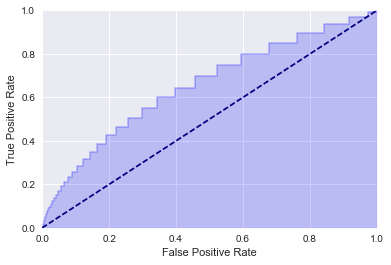

AUC=0.67295


In [43]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipeline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

新しいパラメータを加えて再度モデルの評価を行なった結果、AUCが0.67145から0.67295へ上がった。（AUC +0.0015）

#### ランダムフォレストで抽出された上位30個の特徴量を用いて再度評価を行なってみる。

In [48]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'BIN_AMT_GOODS_PRICE',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'BIN_NUM_OF_NAN',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'BIN_AMT_INCOME_TOTAL',
                         'BIN_DEG_IRESP_INCOME_GOODS_PRICE',
                         'DAYS_ID_PUBLISH',
                         'DEG_IRESP_INCOME_GOODS_PRICE',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [49]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,BIN_AMT_GOODS_PRICE,LIVE_CITY_NOT_WORK_CITY,BIN_NUM_OF_NAN,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,BIN_AMT_INCOME_TOTAL,BIN_DEG_IRESP_INCOME_GOODS_PRICE,DAYS_ID_PUBLISH,DEG_IRESP_INCOME_GOODS_PRICE,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
0,0.083037,0.262949,-3648.0,-637,0.018801,406597.5,-9461,2.0,202500.0,House / apartment,24700.5,0,WEDNESDAY,2,0,0,Business Entity Type 3,0,2,0.0,2.0,No,1.0,4.0,1,-2120,18.0,Secondary / secondary special,block of flats,Laborers,1
1,0.311267,0.622246,-1186.0,-1188,0.003541,1293502.5,-16765,0.0,270000.0,House / apartment,35698.5,0,MONDAY,6,0,0,School,0,1,0.0,0.0,No,0.0,6.0,2,-291,28.0,Higher education,block of flats,Core staff,0
2,NaN,0.555912,-4260.0,-225,0.010032,135000.0,-19046,0.0,67500.0,House / apartment,6750.0,0,MONDAY,0,0,7,Government,0,2,0.0,0.0,NaN,0.0,1.0,0,-2531,9.0,Secondary / secondary special,NaN,Laborers,0
3,NaN,0.650442,-9833.0,-3039,0.008019,312682.5,-19005,0.0,135000.0,House / apartment,29686.5,0,WEDNESDAY,1,0,9,Business Entity Type 3,0,2,NaN,0.0,NaN,NaN,3.0,1,-2437,14.0,Secondary / secondary special,NaN,Laborers,0
4,NaN,0.322738,-4311.0,-3038,0.028663,513000.0,-19932,0.0,121500.0,House / apartment,21865.5,0,THURSDAY,3,1,8,Religion,0,2,0.0,0.0,NaN,0.0,2.0,3,-3458,32.0,Secondary / secondary special,NaN,Core staff,0


In [50]:
#オブジェクト型データをエンコーディング
object_data_home_credit = pd_reducted_train_data.select_dtypes(['object'])
object_col_name = object_data_home_credit.columns.values
array_object_to_int = np.array([object_data_home_credit[object_col_name[i]].unique() for i in range(0,len(object_col_name))])

#オブジェクト型を数値に置き換え
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_reducted_train_data[object_col_name[i]])
    pd_reducted_train_data[object_col_name[i]] = labels    

pd_reducted_train_data = pd_reducted_train_data.replace(np.nan, -1)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


元データ数：307511　学習データ数：230633　検証データ数：76878


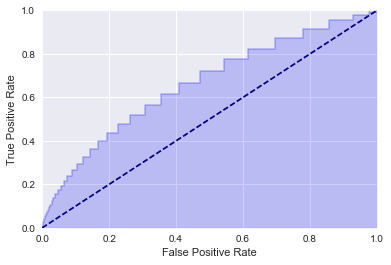

AUC=0.68148


In [51]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipeline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

ランダムフォレストによる重要度算出の結果から選ばれた上位３０個の特徴量を用いた結果、上位10個を用いた場合に比べAUCが0.01上がった。

### 結果まとめ
ここまでで行なった結果では、モデル入力する特徴量を増やすことが一番有効であった。  
学習データに含まれる外れ値や空白を適切に処理して改善を試みる。

| 方法 | AUC |
|:-----------:|:-----------:|
| 重要度算出結果の上位10個を用いた場合 | 0.67145 |
| 新しい特徴量を追加した場合| 0.67295|
| 新しい特徴量を追加 <br>+ 重要度算出結果の上位30個を用いた場合 | 0.68148 |

### Kaggle 提出データを作る

In [64]:
#test.csvを読む
pd_application_test = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/home_credit/application_test.csv")

#借り入れ量
binning_data(pd_application_test, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_test["BIN_AMT_INCOME_TOTAL"] = pd_application_test["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_test, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_test["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_test["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_test["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_test, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_test["BIN_AMT_INCOME_TOTAL"] = pd_application_test["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_test["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_test["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_test["CNT_CHILDREN"])
binning_data(pd_application_test, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_test["NUM_OF_NAN"] = pd_application_test.isnull().sum(axis=1)
binning_data(pd_application_test, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_test.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_test[object_col_name[i]])
    pd_application_test[object_col_name[i]] = labels    

pd_application_test = pd_application_test.replace(np.nan, -1)

range label=0 : range=0.00000~49218.00000
range label=1 : range=49218.00000~98436.00000
range label=2 : range=98436.00000~147654.00000
range label=3 : range=147654.00000~196872.00000
range label=4 : range=196872.00000~246090.00000
range label=5 : range=246090.00000~295308.00000
range label=6 : range=295308.00000~344526.00000
range label=7 : range=344526.00000~393744.00000
range label=0 : range=0.00000~154687.00000
range label=1 : range=154687.00000~309374.00000
range label=2 : range=309374.00000~464061.00000
range label=3 : range=464061.00000~618748.00000
range label=4 : range=618748.00000~773435.00000
range label=5 : range=773435.00000~928122.00000
range label=6 : range=928122.00000~1082809.00000
range label=7 : range=1082809.00000~1237496.00000
range label=0 : range=0.00000~49218.00000
range label=1 : range=49218.00000~98436.00000
range label=2 : range=98436.00000~147654.00000
range label=3 : range=147654.00000~196872.00000
range label=4 : range=196872.00000~246090.00000
range label=

元データ数：307511　学習データ数：230633　検証データ数：76878


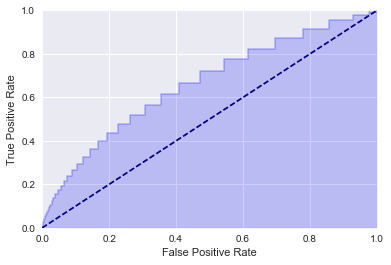

In [68]:
#test data作成
pd_test_data = pd_application_test[selected_feature_name]

#Sample_submissionを読む
pd_submission = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/home_credit/sample_submission.csv")

#モデルを使って予測
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipeline(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, False)

In [77]:
#test dataに対して予測
result_testdata = clf.predict_proba(pd_test_data)

#結果をSample_submissionデータフレームへ
print(result_testdata[:,1])

#print( pd_submission.head() )
pd_submission["TARGET"] = result_testdata[:,1]

#Csvで保存
pd_submission.to_csv("/Users/naoki/Desktop/DIC/Sprint/Sprint1/1st_submission.csv", index=False)

[0.58 0.29 0.33 ... 0.28 0.33 0.33]


# ここからSprint1

In [ ]:
#Trainデータ読み込み
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [94]:
#データ下処理

#借り入れ量
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)
binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_train.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_train[object_col_name[i]])
    pd_application_train[object_col_name[i]] = labels    

pd_application_train = pd_application_train.replace(np.nan, -1)

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range labe

#### 【問題1】クロスバリデーション
事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。
具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

元データ数：246008　学習データ数：184506　検証データ数：61502


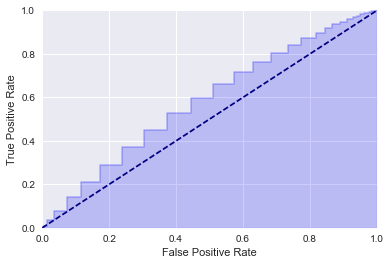

AUC=0.59617
元データ数：246009　学習データ数：184506　検証データ数：61503


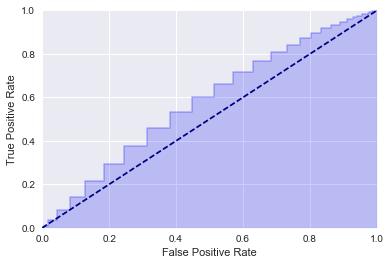

AUC=0.60003
元データ数：246009　学習データ数：184506　検証データ数：61503


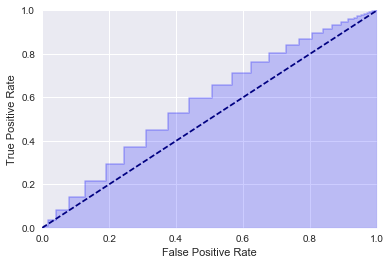

AUC=0.60244
元データ数：246009　学習データ数：184506　検証データ数：61503


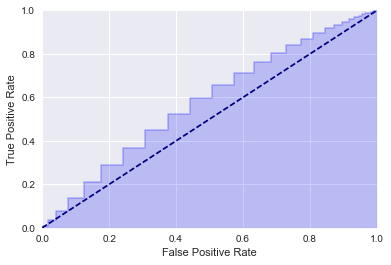

AUC=0.60984
元データ数：246009　学習データ数：184506　検証データ数：61503


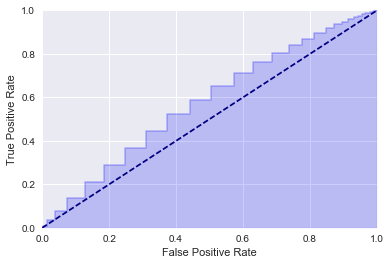

AUC=0.60695


In [108]:
#Kfold CV用データを作成
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(
    pd_application_train[selected_feature_name].values, 
    pd_application_train["TARGET"].values):
    
    #print("TRAIN:", train_index)
    #print("TEST:", test_index)
    cv_train = pd_application_train.iloc[train_index]
    cv_test = pd_application_train.iloc[test_index]
    
    result, fpr, tpr, thresholds = pipeline(clf, cv_train, "TARGET", selected_feature_name, 1, False)
    #print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))
    
    result = clf.predict_proba(cv_test[selected_feature_name].values)
    fpr, tpr, thresholds = metrics.roc_curve(cv_test["TARGET"].values, result[:,1], pos_label=1)
    print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

In [124]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

def pipeline_w_cv(
                   model, data, target_value, feature_value, positive_label, 
                   normalization=True, plot=True, 
                   cv_split=5, cv_random_state=None, cv_shuffle=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    auc_total = 0
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=cv_split, random_state=cv_random_state, shuffle=cv_shuffle)
    for train_index, test_index in skf.split(
        data[feature_value].values, 
        data[target_value].values):
        
        cv_train = data.iloc[train_index]
        cv_test = data.iloc[test_index]
        
        #学習データ、テストデータに分ける
        train_feature = cv_train[feature_value].values
        train_target = cv_train[target_value].values
        test_feature = cv_test[feature_value].values
        test_target = cv_test[target_value].values
        
        #学習データの特徴量を標準化
        if normalization == True:
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)
            
        #学習と予測
        model.fit(train_feature, train_target)
        result = model.predict_proba(test_feature)
        
        #rocを計算
        fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
        auc = metrics.auc(fpr, tpr)
        auc_total += auc
        print("AUC={:.5f}".format(auc))
        
        #rocをplot
        if plot == True:
            plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
            plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.ylim([0.0, 1.0])
            plt.xlim([0.0, 1.0])
            plt.show()
    
    print("Ave AUC : {}".format(auc_total/cv_split))
    
    return

AUC=0.68198


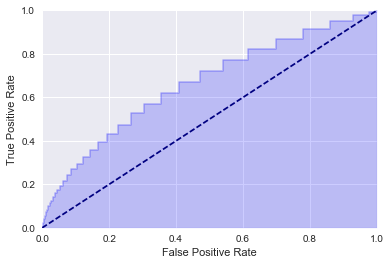

AUC=0.68416


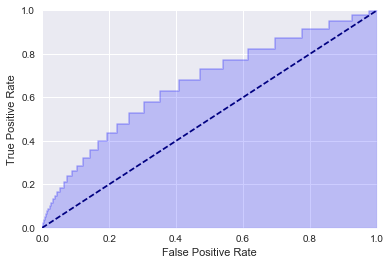

AUC=0.67950


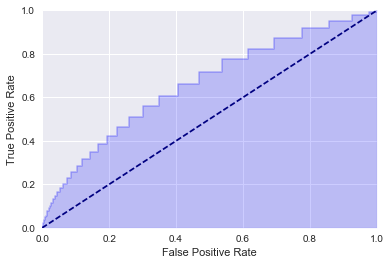

AUC=0.68166


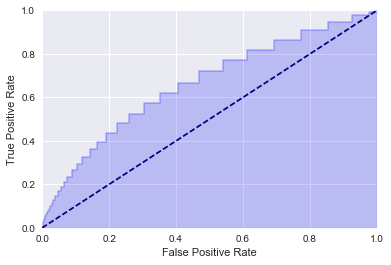

AUC=0.68065


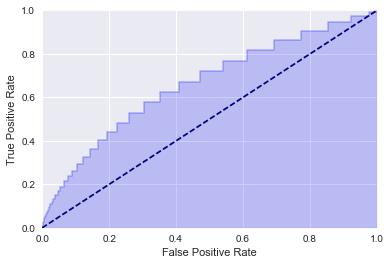

In [117]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
pipeline_w_cv(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, True, False, False)

#### 【問題2】グリッドサーチ
これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。
グリッドサーチをパイプラインの中に組み込みましょう。

In [96]:
#Report top scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [126]:
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)

#Random forestパラメーター
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators" : [30, 50, 100],
              "random_state" : [10, 50, 100]
             }

#時間がかかるのでtrain dataを30000件に絞る
tmp = pd_application_train.sample(n=30000)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
grid_search.fit(tmp[selected_feature_name].values, tmp["TARGET"].values)
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.918 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10, 'n_estimators': 30, 'random_state': 10}

Model with rank: 1
Mean validation score: 0.918 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 30, 'random_state': 50}

Model with rank: 1
Mean validation score: 0.918 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 100}

Model with rank: 1
Mean validation score: 0.918 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 30, 'random_state': 50}

Model with rank: 1
Mean validation score: 0.918 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_dep

In [119]:
print("Best param ",grid_search.best_params_)

Best param  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 30, 'random_state': 100}


#### Grid searchの結果を反映＆再評価

AUC=0.65525


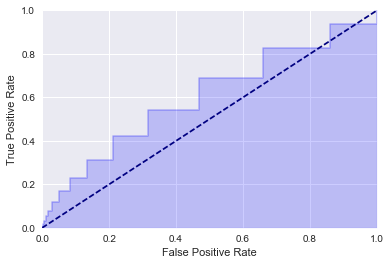

AUC=0.64871


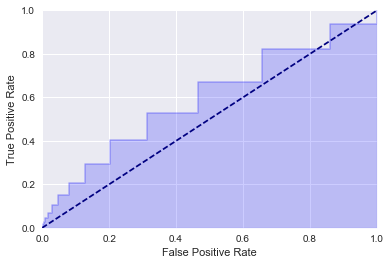

AUC=0.65977


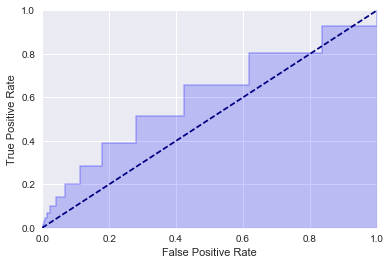

AUC=0.65288


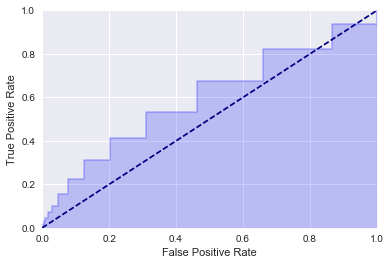

AUC=0.65134


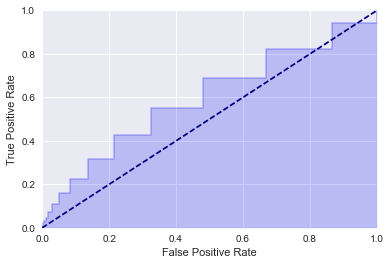

Ave AUC : 0.6535878461955859


In [138]:
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")
pipeline_w_cv(clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, 
              True, True, 
              5, None, True)

In [140]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [141]:
def plot_roc(fpr, tpr):
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.show()

In [142]:
def train_model(model, train_feature, train_target, test_feature, test_target, positive_label):
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
        
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    auc = metrics.auc(fpr, tpr)
    print("AUC={:.5f}".format(auc))
    
    return result, fpr, tpr, auc

In [150]:
def pipeline_w_cv_grid(
            model, data, target_value, feature_value, positive_label, 
            normalization_on=True, roc_plot_on=True, 
            cv_on=True, cv_split=5, cv_random_state=None, cv_shuffle=True,
            grid_search_on=True, param_grid={}):
    
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    auc = 0
    if cv_on == True:
        print("Run cross validation")
        scaler = StandardScaler()
        skf = StratifiedKFold(n_splits=cv_split, random_state=cv_random_state, shuffle=cv_shuffle)
        for train_index, test_index in skf.split(
            data[feature_value].values, 
            data[target_value].values):
            
            cv_train = data.iloc[train_index]
            cv_test = data.iloc[test_index]
        
            #学習データ、テストデータに分ける
            train_feature = cv_train[feature_value].values
            train_target = cv_train[target_value].values
            test_feature = cv_test[feature_value].values
            test_target = cv_test[target_value].values
        
            #学習データの特徴量を標準化
            if normalization_on == True:
                print("Normalize feature data")
                scaler.fit(train_feature)
                train_feature = scaler.transform(train_feature)
                scaler.fit(test_feature)
                test_feature = scaler.transform(test_feature)
            
            #学習と予測
            result, fpr, tpr, auc_from_cv = train_model(model, train_feature, train_target, test_feature, test_target, positive_label)
            print("Auc_from_cv=", auc_from_cv )
            auc += auc_from_cv/cv_split
            #rocをplot
            if roc_plot_on == True:
                plot_roc(fpr, tpr)
                
    else:
        #学習データ、テストデータに分ける
        print("Split data train & test")
        train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
        train_feature = train_data[feature_value].values
        train_target = train_data[target_value].values
        test_feature = test_data[feature_value].values
        test_target = test_data[target_value].values
        print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
           
        if normalization_on == True:
            print("Normalize feature data")
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)
        
        #学習と予測
        result, fpr, tpr, auc = train_model(train_feature, train_target, test_feature, test_target, positive_label)
            
        #rocをplot
        if roc_plot_on == True:
            plot_roc(fpr, tpr)
            
    print("AUC : {}".format(auc))
    
    if grid_search_on == True:
        #時間がかかるのでtrain dataを30000件に絞る
        tmp = pd_application_train.sample(n=30000)
        grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
        grid_search.fit(tmp[selected_feature_name].values, tmp["TARGET"].values)
        model.set_params(**grid_search.best_params_)
        print("Set best params ",grid_search.best_params_)
        
    return result, fpr, tpr, auc, grid_search.best_params_

Run cross validation
Normalize feature data
AUC=0.65849
Auc_from_cv= 0.6584911302169549


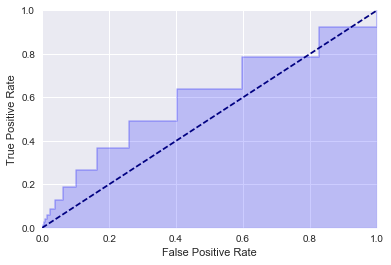

Normalize feature data
AUC=0.65028
Auc_from_cv= 0.6502809406858172


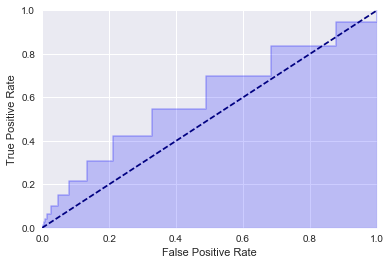

AUC : 0.6543860354513861
Set best params  {'max_depth': 3, 'max_features': 1}


(array([[0.93333333, 0.06666667],
        [0.9       , 0.1       ],
        [1.        , 0.        ],
        ...,
        [0.86666667, 0.13333333],
        [0.8       , 0.2       ],
        [1.        , 0.        ]]),
 array([0.00000000e+00, 7.07498780e-06, 1.41499756e-05, 4.24499268e-05,
        1.27349780e-04, 2.40549585e-04, 5.23549097e-04, 1.20274793e-03,
        2.58944553e-03, 4.71194187e-03, 8.63148511e-03, 1.55508232e-02,
        2.73660528e-02, 4.73316684e-02, 8.01030118e-02, 1.32493296e-01,
        2.11527985e-01, 3.28703933e-01, 4.88499607e-01, 6.84724394e-01,
        8.78954034e-01, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 2.41701579e-04, 4.83403158e-04,
        1.20850790e-03, 3.06155334e-03, 4.99516597e-03, 7.08991299e-03,
        1.40186916e-02, 2.45729939e-02, 4.01224621e-02, 6.38092169e-02,
        9.80502739e-02, 1.49210442e-01, 2.16000645e-01, 3.09297454e-01,
        4.19916210e-01, 5.48582017e-01, 6.98275862e-01, 8.37173703e-01,
        9.44650338e

In [151]:
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")

#Random forestパラメーター
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
             }

#Run pipeline
pipeline_w_cv_grid(
              clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, 
              True, True, 
              True, 2, None, True,
              True, param_grid)

Pipelineを作り直した。
CV, Grid searchを含む

In [227]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [141]:
def plot_roc(fpr, tpr):
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.show()

In [142]:
def train_model(model, train_feature, train_target, test_feature, test_target, positive_label):
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
        
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    auc = metrics.auc(fpr, tpr)
    print("AUC={:.5f}".format(auc))
    
    return result, fpr, tpr, auc

In [321]:
def pipeline2(model, data, target_value, feature_value, pos_label=1, params={}, params_grid={}):
    
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    pos_label : 目的変数 Positive label指定
    Params :  この関数のパラメーター達
    params_grid : GridSearchのパラメータ達
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    auc_total = 0
    if params.get("cv_on") == True:
        print("Run cross validation")
        train_x = [0 for _ in range(params.get("cv_split"))]
        train_y = [0 for _ in range(params.get("cv_split"))]
        test_x = [0 for _ in range(params.get("cv_split"))]
        test_y = [0 for _ in range(params.get("cv_split"))]    
        
        scaler = StandardScaler()
        skf = StratifiedKFold(
                            n_splits=params.get("cv_split"), 
                            random_state=params.get("cv_random_state"), 
                            shuffle=params.get("cv_shuffle"))
        
        i = 0
        for train_index, test_index in skf.split(
            data[feature_value].values, 
            data[target_value].values):
            
            cv_train = data.iloc[train_index]
            cv_test = data.iloc[test_index]
        
            #学習データ、テストデータに分ける
            train_x[i] = cv_train[feature_value].values
            train_y[i] = cv_train[target_value].values
            test_x[i] = cv_test[feature_value].values
            test_y[i] = cv_test[target_value].values
            i +=1
            
    else:
        #学習データ、テストデータに分ける  
        print("Split data train & test")
        train_x = [0]
        train_y = [0]
        test_x = [0]
        test_y = [0]          
        
        train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
        train_x[0] = train_data[feature_value].values
        train_y[0] = train_data[target_value].values
        test_x[0] = test_data[feature_value].values
        test_y[0] = test_data[target_value].values
        print("元データ数：{}　学習データ数：{}　検証データ数：{}"
                                  .format(len(data), len(train_data), len(test_data)))
                 
    for num in range(0, len(train_x)):
        train_feature = train_x[num]
        train_target = train_y[num]
        test_feature = test_x[num]
        test_target = test_y[num]
        
        if params.get("normalization_on") == True:
            print("Normalize feature data")
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)

            #学習と予測
            result, fpr, tpr, auc = train_model(
                                        model, 
                                        train_feature, train_target,
                                        test_feature, test_target,
                                        pos_label)
            print("Auc : ", auc)
            auc_total += auc

            #rocをplot
            if params.get("roc_plot_on") == True:
                plot_roc(fpr, tpr)
                
    if params.get("cv_on") == True:
        print("AUC for cv (Ave of {} cv split) : {}".format(i, (auc_total / i)))

    if params.get("grid_search_on") == True:
        #時間がかかるのでtrain dataを30000件に絞る
        tmp = data.sample(n=30000)
        grid_search = GridSearchCV(
                    clf,
                    param_grid=params_grid.get("hyper_param"), 
                    cv=params_grid.get("grid_search_param",{}).get("grid_search_cv"))
            
        grid_search.fit(tmp[feature_value].values, tmp[target_value].values)
        model.set_params(**grid_search.best_params_)
        print("Set best params ",grid_search.best_params_)

    return result, fpr, tpr, auc

Run cross validation
Normalize feature data
AUC=0.64946
Auc :  0.6494563192199931


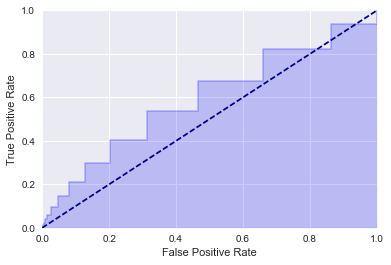

Normalize feature data
AUC=0.65818
Auc :  0.6581777830499065


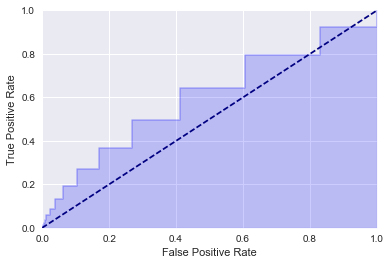

AUC for cv (Ave of 2 cv split) : 0.6538170511349498
Set best params  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 30, 'random_state': 50}


(array([[0.93333333, 0.06666667],
        [0.83333333, 0.16666667],
        [0.96666667, 0.03333333],
        ...,
        [1.        , 0.        ],
        [0.73333333, 0.26666667],
        [0.86666667, 0.13333333]]),
 array([0.00000000e+00, 0.00000000e+00, 7.07498780e-06, 5.65999024e-05,
        1.27349780e-04, 2.82999512e-04, 5.44774060e-04, 1.11077308e-03,
        2.05174646e-03, 3.93369321e-03, 7.08206278e-03, 1.24166036e-02,
        2.19466121e-02, 3.75328103e-02, 6.32433159e-02, 1.05028194e-01,
        1.68434234e-01, 2.67837813e-01, 4.11460065e-01, 6.04734582e-01,
        8.28360796e-01, 1.00000000e+00]),
 array([0.00000000e+00, 8.05671930e-05, 4.83403158e-04, 7.25104737e-04,
        1.20850790e-03, 2.09474702e-03, 3.38382211e-03, 7.33161457e-03,
        1.32935869e-02, 2.33644860e-02, 3.61746697e-02, 5.79278118e-02,
        8.79793748e-02, 1.33822108e-01, 1.94408637e-01, 2.69577828e-01,
        3.67305833e-01, 4.95488237e-01, 6.44295843e-01, 7.95359330e-01,
        9.24186271e

In [226]:
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")

#pipelineパラメーター
params_ext = {
         "normalization_on": True,
          "roc_plot_on": True,
          "cv_on": True,
          "cv_split": 2,
          "cv_random_state" : None,
          "cv_shuffle" : True,
          "grid_search_on" : True,
        }
#Grid search
param_grid = {
            "hyper_param":{
                "max_depth": [50, 120],
                "max_features": [3, 10],
                "min_samples_split": [3, 10],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"],
                "n_estimators" : [30, 50, 100],
                "random_state" : [10, 50, 100]
            },
            "grid_search_param":{
                    "grid_search_cv":2
            }
        }

#Run pipeline
pipeline2(
    clf, pd_reducted_train_data, "TARGET", selected_feature_name, 1, 
    params=params_ext, 
    params_grid=param_grid)

#### 【問題3】Kernelからの調査
KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。

1. Automated feature creation
https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics
DPF

2. Hyper param tuning
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
GritSearch, RandomSearch

3. LightGBM
よく使われている。

4. Feature selection
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
"Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set"
==> 選んだ30個のデータに対しこれを行う。(0.9 以上はどちらか一方を使う)

5. Dimentionaly reduction
・PCA, ICA, Manifold learning

6. Polynomial Features(sklearn)
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
==>特徴量を増やす (多項式から算出　例えばdegree=2の場合　[1, a, b, a^2, ab, b^2])

7. 欠損値、外れ値の処理
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction 
この人を参考にする。選んだ30個の特徴量の外れ値を確認。外れ値のindexは削除または平均に置き換える。


In [48]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'BIN_AMT_GOODS_PRICE',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'BIN_NUM_OF_NAN',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'BIN_AMT_INCOME_TOTAL',
                         'BIN_DEG_IRESP_INCOME_GOODS_PRICE',
                         'DAYS_ID_PUBLISH',
                         'DEG_IRESP_INCOME_GOODS_PRICE',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [307]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'DAYS_ID_PUBLISH',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [305]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/home_credit/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [306]:
#借り入れ量
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)
binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_train.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_train[object_col_name[i]])
    pd_application_train[object_col_name[i]] = labels    

pd_application_train = pd_application_train.replace(np.nan, -1)

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range labe

In [308]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.describe()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,23827.150414,46901.170583,5922.236118,2538.720384,27.696609,556.241416,7913.592219,1.060021,34.912172,0.273772,2663.782219,0.417312,2.96231,0.179555,9.546556,0.056720,0.396366,0.098055,1.079366,-0.466413,1.678688,2530.838006,0.349649,-0.488070,2.280504,0.919271
std,34742.540153,32821.881130,3765.009888,2534.048092,19.595369,829.327591,4763.152782,0.327226,149.230919,0.829839,2843.531578,0.723469,2.16452,0.383817,10.846045,0.231307,0.724237,0.735406,0.378965,0.513823,2.206728,1587.148893,0.612447,0.535714,3.830350,0.272419
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,-1.000000,18389.000000,2713.000000,395.000000,12.000000,59.000000,3789.000000,1.000000,4.000000,0.000000,448.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,1158.000000,0.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,42363.000000,5600.000000,1905.000000,22.000000,189.000000,7740.000000,1.000000,12.000000,0.000000,1607.000000,0.000000,3.00000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2396.000000,0.000000,-1.000000,1.000000,1.000000
75%,45141.500000,72025.000000,8835.000000,3920.000000,40.000000,689.000000,11888.000000,1.000000,21.000000,0.000000,4044.000000,1.000000,5.00000,0.000000,12.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3840.000000,1.000000,0.000000,5.000000,1.000000
max,114583.000000,119830.000000,15687.000000,12573.000000,80.000000,5602.000000,17459.000000,8.000000,2547.000000,5.000000,13671.000000,14.000000,6.00000,1.000000,57.000000,1.000000,2.000000,10.000000,9.000000,1.000000,24.000000,6167.000000,4.000000,2.000000,17.000000,1.000000


#### 1. Polynomial Features

In [284]:
# Make a new dataframe for polynomial features
poly_features = pd_application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
#poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(['TARGET'], axis=1)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
#poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [285]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
#poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [286]:
poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

効果の確認

In [309]:
from sklearn.preprocessing import MinMaxScaler
#元データに新しい特徴量を追加
# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))
poly_features = scaler.fit_transform(poly_features)
#poly_features.shape

#poly featureをpandas dataframeへ
poly_col_name = poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

pd_poly_features = pd.DataFrame(poly_features, columns=poly_col_name)
pd_poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_3^2,EXT_SOURCE_3 DAYS_BIRTH,DAYS_BIRTH^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,0.0,0.072215,0.307542,0.155054,0.888839,0.007213,0.029266,0.014650,0.972251,0.094582,0.052001,0.877712,0.024196,0.939295,0.057589,0.000638,0.002563,0.001302,0.997169,0.009369,0.004920,0.988523,0.002314,0.994389,0.010628,0.029088,0.016330,0.960392,0.008212,0.979415,0.046172,0.003764,0.990344,0.023077,0.972706
1,0.0,0.312933,0.727773,0.597163,0.477114,0.104337,0.259609,0.211148,0.784027,0.529654,0.472602,0.487207,0.356887,0.585786,0.387618,0.033798,0.085217,0.070268,0.927302,0.196667,0.167608,0.819600,0.127953,0.856692,0.145382,0.385468,0.351196,0.606970,0.286645,0.668486,0.343083,0.213204,0.747619,0.278936,0.725543
2,0.0,0.518318,0.650190,0.814130,0.348534,0.276097,0.377033,0.467854,0.596395,0.422747,0.575475,0.479542,0.662986,0.358523,0.528353,0.145203,0.201187,0.253093,0.781565,0.255173,0.331772,0.702357,0.386401,0.639268,0.307086,0.274866,0.382054,0.643619,0.475732,0.541400,0.395588,0.539830,0.467363,0.490717,0.585062
3,0.0,0.518318,0.760751,0.597163,0.350846,0.276097,0.441145,0.343255,0.597276,0.578742,0.494017,0.392352,0.356887,0.530418,0.525665,0.145203,0.235398,0.185692,0.782036,0.349332,0.284810,0.652494,0.208001,0.735906,0.305757,0.440278,0.383744,0.513163,0.299633,0.607162,0.460865,0.213204,0.713898,0.358470,0.587909
4,0.0,0.518318,0.377472,0.597163,0.298591,0.276097,0.218889,0.343255,0.577359,0.142485,0.245123,0.683789,0.356887,0.507504,0.587852,0.145203,0.116800,0.185692,0.771400,0.086005,0.141318,0.819163,0.208001,0.723024,0.336500,0.053784,0.094477,0.874296,0.148673,0.795573,0.251525,0.213204,0.699943,0.394299,0.520494


In [310]:
train_data_w_poly = pd.concat([pd_application_train, pd_poly_features], axis=1)

In [317]:
#selected_feature_name_w_poly = copy.deepcopy(selected_feature_name)
#selected_feature_name_w_poly.append(poly_col_name)
selected_feature_name_w_poly = selected_feature_name + poly_col_name
print(selected_feature_name_w_poly)

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE', 'AMT_CREDIT', 'DAYS_BIRTH', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'WEEKDAY_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_ID_PUBLISH', 'NAME_EDUCATION_TYPE', 'HOUSETYPE_MODE', 'OCCUPATION_TYPE', '1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 

Run cross validation
Normalize feature data
AUC=0.68929
Auc :  0.6892908411874027


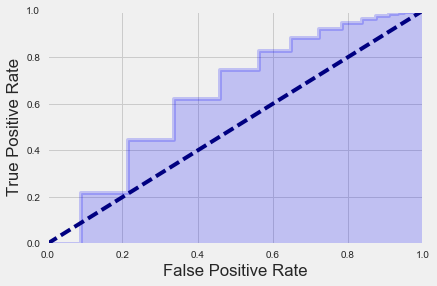

Normalize feature data
AUC=0.67692
Auc :  0.676916801678823


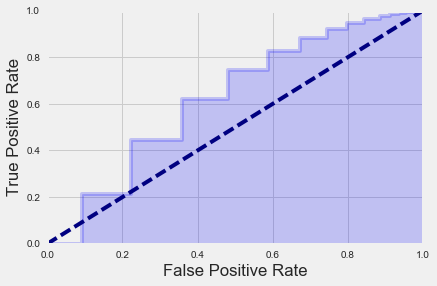

Normalize feature data
AUC=0.68168
Auc :  0.6816794324158243


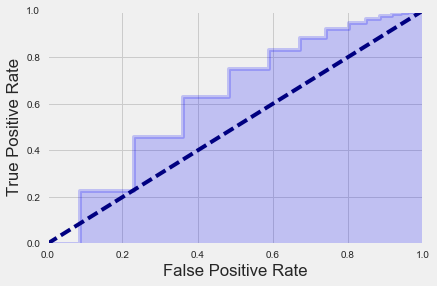

Normalize feature data
AUC=0.68530
Auc :  0.6852991992107905


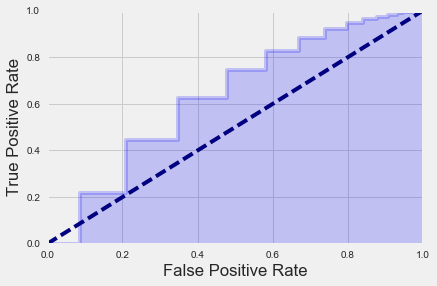

Normalize feature data
AUC=0.67760
Auc :  0.6775973673257418


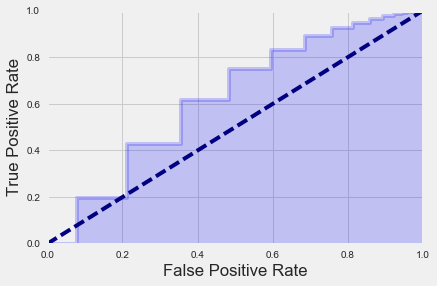

AUC for cv (Ave of 5 cv split) : 0.6821567283637165


(array([[0.1       , 0.9       ],
        [0.1       , 0.9       ],
        [0.06666667, 0.93333333],
        ...,
        [0.06666667, 0.93333333],
        [0.2       , 0.8       ],
        [0.        , 1.        ]]),
 array([0.        , 0.07814703, 0.212286  , 0.35468278, 0.48318228,
        0.59657603, 0.68479355, 0.75689829, 0.81309164, 0.85820745,
        0.89425982, 0.92366566, 0.94420947, 0.95810675, 0.97160121,
        0.98006042, 0.98670695, 0.99113797, 0.99375629, 0.99617321,
        0.9979859 , 0.99879154, 0.99959718, 0.99979859, 1.        ]),
 array([0.        , 0.19650848, 0.42777296, 0.61609212, 0.74740435,
        0.8320392 , 0.88883386, 0.92422661, 0.94805172, 0.96441269,
        0.97541433, 0.98319684, 0.98922829, 0.99281886, 0.99556043,
        0.99720537, 0.99821356, 0.99885031, 0.99945169, 0.99969931,
        0.99987619, 0.99991156, 0.99998231, 1.        , 1.        ]),
 0.6775973673257418)

In [322]:
#Pipelineを回す
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")

#pipelineパラメーター
POSITIVE_LABEL = 1

params_ext = {
         "normalization_on": True,
          "roc_plot_on": True,
          "cv_on": True,
          "cv_split": 5,
          "cv_random_state" : None,
          "cv_shuffle" : True,
          "grid_search_on" : False,
        }
#Grid search
param_grid = {
            "hyper_param":{
                "max_depth": [50, 120],
                "max_features": [3, 10],
                "min_samples_split": [3, 10],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"],
                "n_estimators" : [30, 50, 100],
                "random_state" : [10, 50, 100]
            },
            "grid_search_param":{
                    "grid_search_cv":2
            }
        }

#Run pipeline
pipeline2(
    clf, train_data_w_poly, "TARGET", selected_feature_name_w_poly, POSITIVE_LABEL, 
    params=params_ext, 
    params_grid=param_grid)

#### 2. 外れ値の処理
これまでIQR x 1.5のデータ範囲を決めたため、外れ値は最大binに割り振られている。
それ以外のデータについては外れ値の確認が必要

In [304]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'DAYS_ID_PUBLISH',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [270]:
def plot_hist(data, col_name):
    # Set the style of plots
    plt.style.use('fivethirtyeight')
    # Plot the distribution of ages in years
    plt.hist(data[col_name], edgecolor = 'k', bins = 25)
    plt.title(col_name); plt.xlabel("X"); plt.ylabel('Count'); 
    plt.show()

In [256]:
pd_reducted_train_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
0,0.083037,0.262949,-3648.0,-637,0.018801,406597.5,-9461,2.0,202500.0,House / apartment,24700.5,0,WEDNESDAY,0,Business Entity Type 3,0,2,0.0,2.0,No,1.0,-2120,Secondary / secondary special,block of flats,Laborers,1
1,0.311267,0.622246,-1186.0,-1188,0.003541,1293502.5,-16765,0.0,270000.0,House / apartment,35698.5,0,MONDAY,0,School,0,1,0.0,0.0,No,0.0,-291,Higher education,block of flats,Core staff,0
2,NaN,0.555912,-4260.0,-225,0.010032,135000.0,-19046,0.0,67500.0,House / apartment,6750.0,0,MONDAY,0,Government,0,2,0.0,0.0,NaN,0.0,-2531,Secondary / secondary special,NaN,Laborers,0
3,NaN,0.650442,-9833.0,-3039,0.008019,312682.5,-19005,0.0,135000.0,House / apartment,29686.5,0,WEDNESDAY,0,Business Entity Type 3,0,2,NaN,0.0,NaN,NaN,-2437,Secondary / secondary special,NaN,Laborers,0
4,NaN,0.322738,-4311.0,-3038,0.028663,513000.0,-19932,0.0,121500.0,House / apartment,21865.5,0,THURSDAY,1,Religion,0,2,0.0,0.0,NaN,0.0,-3458,Secondary / secondary special,NaN,Core staff,0


In [292]:
object_data = pd_reducted_train_data.select_dtypes(['object'])
num_data = pd_reducted_train_data.drop(object_data.columns.values, axis=1)

In [293]:
num_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,AMT_ANNUITY,CNT_CHILDREN,LIVE_CITY_NOT_WORK_CITY,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,TARGET
0,0.083037,0.262949,-3648.0,-637,0.018801,406597.5,-9461,2.0,202500.0,24700.5,0,0,0,2,0.0,2.0,1.0,-2120,1
1,0.311267,0.622246,-1186.0,-1188,0.003541,1293502.5,-16765,0.0,270000.0,35698.5,0,0,0,1,0.0,0.0,0.0,-291,0
2,NaN,0.555912,-4260.0,-225,0.010032,135000.0,-19046,0.0,67500.0,6750.0,0,0,0,2,0.0,0.0,0.0,-2531,0
3,NaN,0.650442,-9833.0,-3039,0.008019,312682.5,-19005,0.0,135000.0,29686.5,0,0,0,2,NaN,0.0,NaN,-2437,0
4,NaN,0.322738,-4311.0,-3038,0.028663,513000.0,-19932,0.0,121500.0,21865.5,0,1,0,2,0.0,0.0,0.0,-3458,0


In [294]:
num_data = np.abs(num_data)

In [296]:
col_name = num_data.columns.values
#num_data = num_data.replace(np.nan, -9999)
for i in range(0, len(col_name)):
    plot_data = num_data[col_name[i]]
    plot_data.dropna(axis = 0, how = 'any')
    plot_hist(plot_data, col_name[i])

KeyError: 'EXT_SOURCE_1'

#### 3. 相関関係の確認とFeature reduction

#### 【問題4】高い汎化性能のモデル
これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。